In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pprint import pprint
from itertools import combinations
from math import ceil
from scipy.stats import linregress
from collections import defaultdict
from Bio import SeqIO
from math import ceil

In [26]:
## Read in data; use the ID to index individual oligos
counts = pd.read_excel('../data/counts/2017.09.28.annotatedCounts.xlsx', index_col=0)
outfile = '../data/counts/2017-09-28_proportions.csv'

def proportions(df):
    ''' For each column, divide each element by the sum of the column (column sums to 1)'''
    xsum=df.sum(0)
    df = df.div(xsum, axis='columns')
    return df

def standardize_subset_data(df, pattern, fn):
    ''' Pull columns that contain the pattern (case insensitive) and apply the standardization function, fn'''
    subset = df[ [c for c in df.columns.values if pattern.upper() in c.upper()] ]
    standardized_subset = fn(subset)
    
    return standardized_subset
    
### For convenience, separate out the metadata, input counts, background counts, and observed counts.
### Standardize each column while we're at it

input_ctrl = standardize_subset_data(counts, 'input', proportions) # Input samples
bkgd_ctrl =  standardize_subset_data(counts, 'beads', proportions) # Beads only background samples
metadata = counts[['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']] # Metadata
output = proportions(counts[[c for c in counts.columns.values if not  # All "real" samples
                 any( [c in input_ctrl.columns.values, 
                       c in bkgd_ctrl.columns.values, 
                       c in metadata.columns.values] )
                ] ] )

In [22]:
sns.set(style='whitegrid', font_scale = 1.3, palette='pastel') ## Make all of our plots prettier

def compare_replicates(df, columns, title):
    ''' Plot sanity checks for technical replicates '''
    if columns:
        replicates = df[columns]    
        replicates.fillna(0, inplace=True)
    else:
        replicates = df
    
    def plot_comparison(x,y, **kwargs):
        r_2 = linregress(x,y)[2]
        scatter = plt.plot(x,y, 'o', alpha=0.4)
        scatter[0].axes.text(0,0, 'R^2 = %.2f'%(r_2))
        return scatter
        
    g = sns.PairGrid(replicates, diag_sharey=False)
    g.map_diag(sns.violinplot)
    g.map_offdiag(plot_comparison, )
    
    g.fig.suptitle(title, va='bottom')
    plt.tight_layout()
    plt.show()

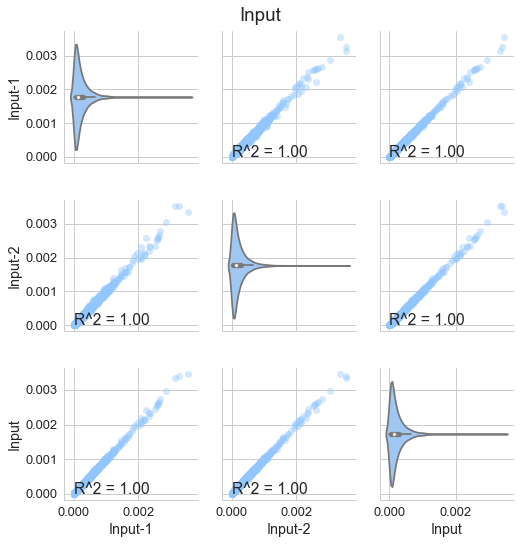

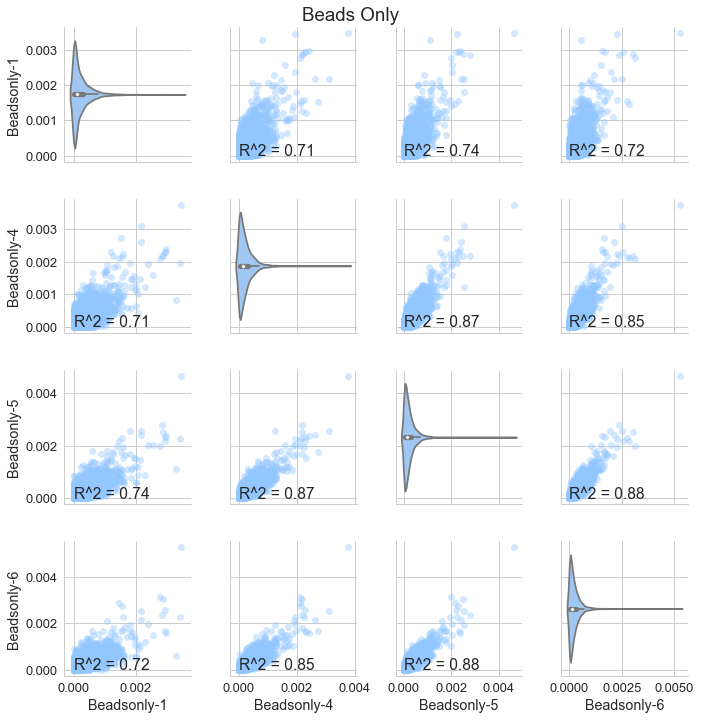

In [29]:
## Sanity check the controls
bkgd_ctrl.drop(['Beadsonly-2', 'Beadsonly-3'], axis=1, inplace=True) # Funky replicates

compare_replicates(input_ctrl, None, 'Input')
compare_replicates(bkgd_ctrl, None, 'Beads Only')

In [30]:
# ### Find the mean of the input and background vals
input_ctrl['average'] = input_ctrl.mean(axis=1)

bkgd_ctrl['average'] = bkgd_ctrl.mean(axis=1)

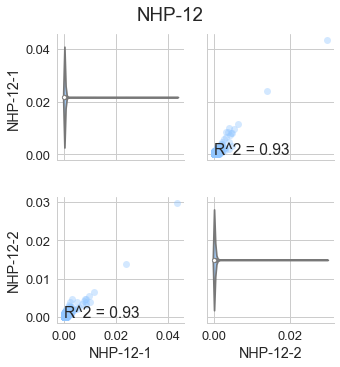

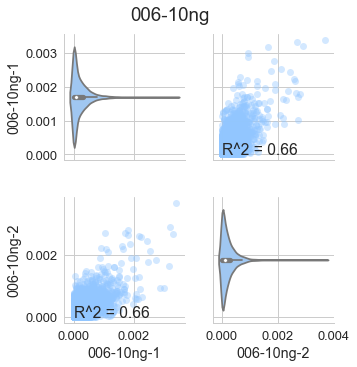

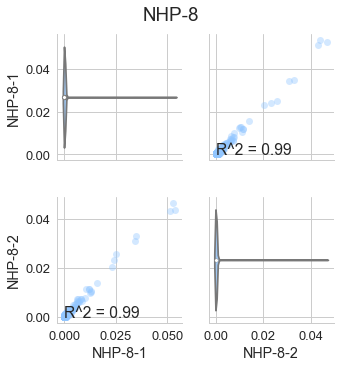

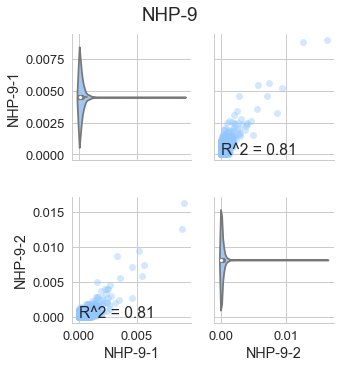

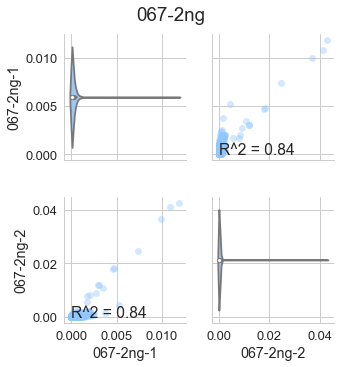

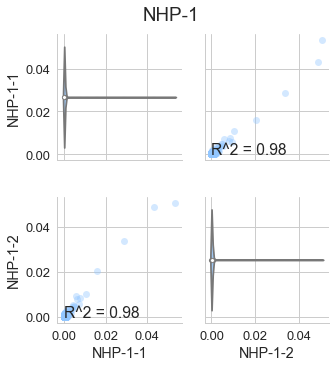

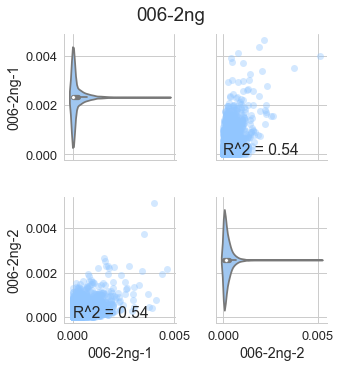

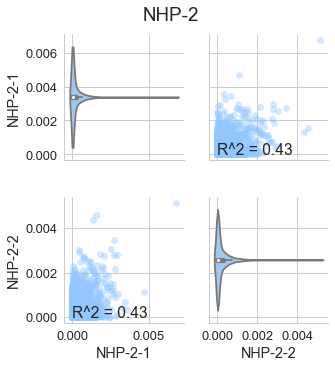

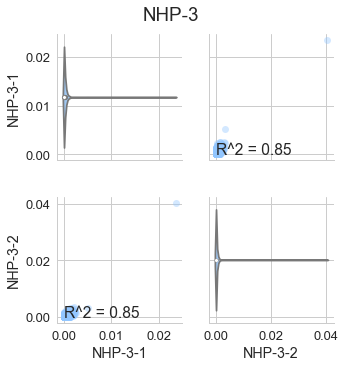

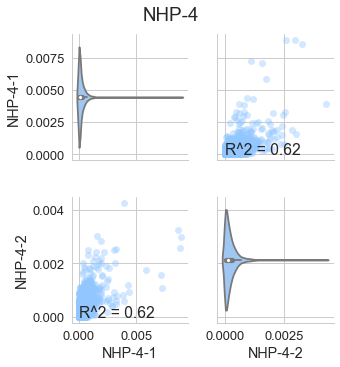

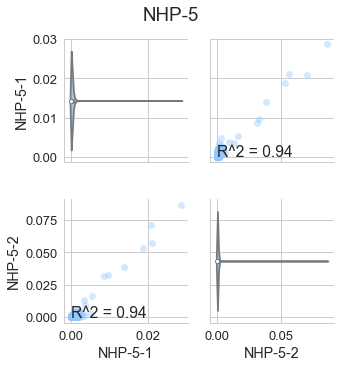

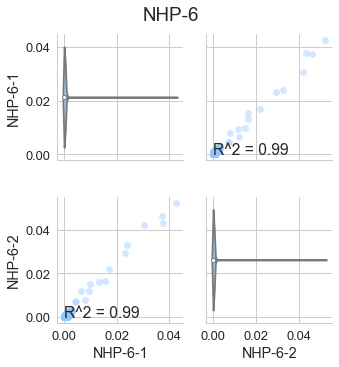

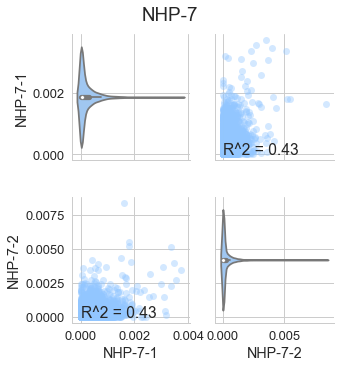

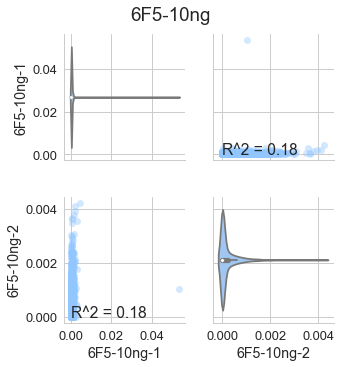

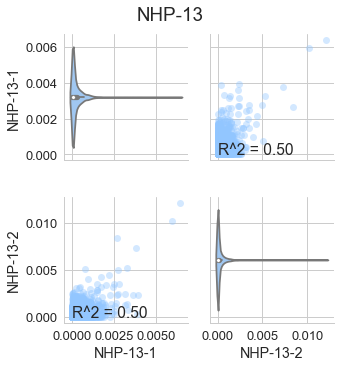

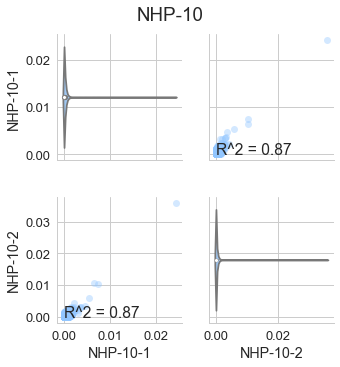

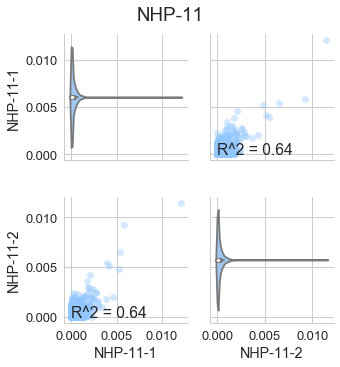

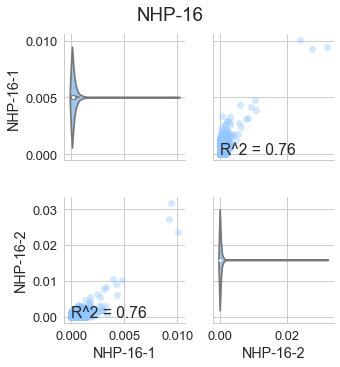

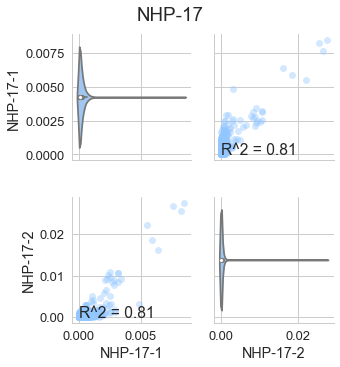

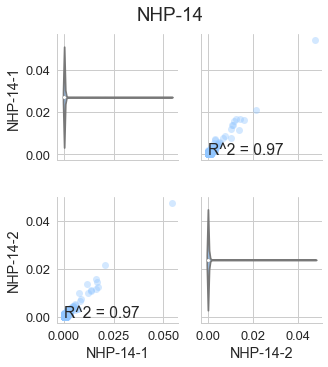

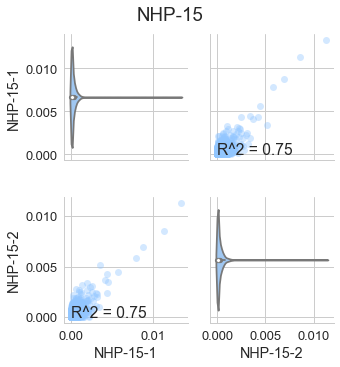

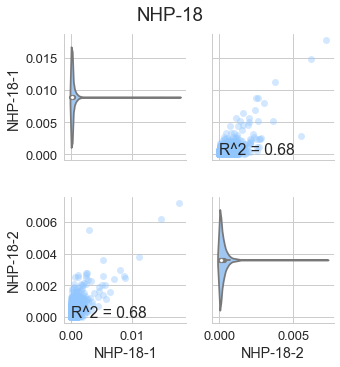

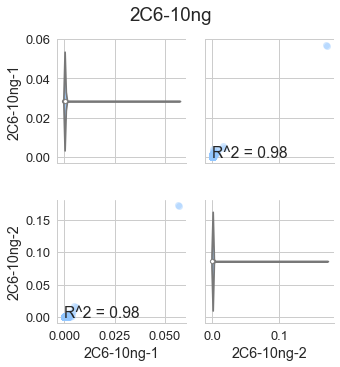

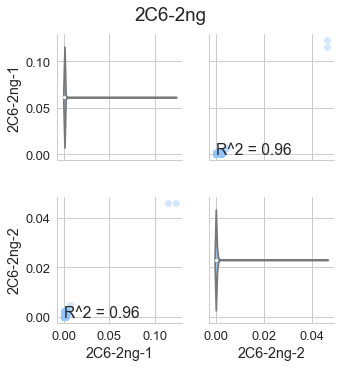

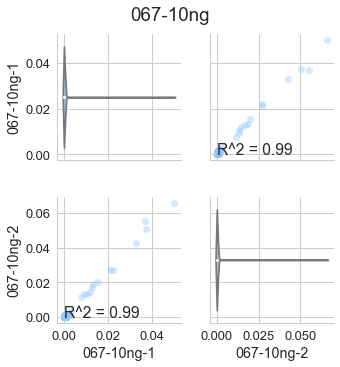

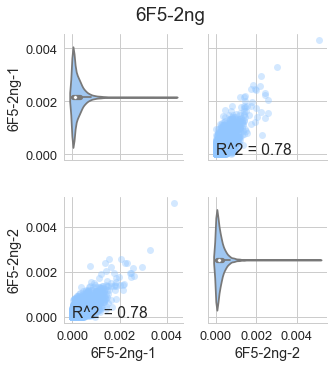

In [33]:
### Look at technical replicates for each sample
replicates = defaultdict(list)
for serum in output.columns.values:
    replicates[serum.rsplit('-', 1)[0]].append(serum) # Find replicates
replicates = dict(replicates) # Turn off defaultdict behavior

for sera, reps in replicates.items():
    compare_replicates(output, reps, sera)

In [34]:
## Add the names of any particular replicates that seem "off" relative to the others
# funky_replicates = ['Flu_3', 'VRC01_3', 'NS1_2', 'DV63_3'] 
# if funky_replicates != []:
#     output_counts.drop(funky_replicates, inplace=True, axis=1)

## Aggregate technical replicates

aggregated_output = pd.DataFrame(index=output.index.values)

for sera, reps in replicates.items():
    aggregated_output[sera] = output[reps].mean(axis=1)
    
print aggregated_output.head()

         NHP-12  006-10ng     NHP-8     NHP-9   067-2ng     NHP-1   006-2ng  \
1      0.000776  0.000610  0.000242  0.000275  0.000425  0.000638  0.000691   
2      0.000175  0.000352  0.000126  0.000459  0.000245  0.000202  0.000463   
3.188  0.000326  0.000868  0.000329  0.000427  0.000511  0.000415  0.000755   
4.189  0.000574  0.000686  0.000243  0.000387  0.000429  0.000794  0.000434   
5.19   0.000355  0.000099  0.000106  0.000270  0.000108  0.000048  0.000056   

          NHP-2     NHP-3     NHP-4    ...       NHP-11    NHP-16    NHP-17  \
1      0.000531  0.000560  0.000478    ...     0.000482  0.000427  0.000332   
2      0.000099  0.000439  0.000261    ...     0.000267  0.000384  0.000161   
3.188  0.000335  0.000333  0.000582    ...     0.000776  0.000282  0.000212   
4.189  0.000838  0.000553  0.000675    ...     0.000742  0.000710  0.000427   
5.19   0.000635  0.000143  0.000348    ...     0.000365  0.000006  0.000185   

         NHP-14    NHP-15    NHP-18  2C6-10ng   2C

In [39]:
### Tidy up the metadata a bit
metadata = counts[['Virus_Strain', 'Start_to_End_nt', 'Peptide_sequence']] # Metadata

## Tidy start and end coordinates --> integers
metadata['start'], metadata['end'] = metadata['Start_to_End_nt'].str.split('to', 1).str
metadata['start'] = metadata['start'].map(lambda x: int(x))
metadata['end'] = metadata['end'].map(lambda x: int(x.split('.')[0])) ## TODO
metadata.drop('Start_to_End_nt', inplace=True, axis=1)

def parse_strains(virusstrain):
    
    if 'HIV' in virusstrain:
        # e.g., 'HIV_Env_QB850.72p.C14_A1.HIV_Env_QB850.632p.B10'
        gene = virusstrain.split('HIV_', 1)[1].split('_', 1)[0] # Env
        virus = 'HIV'+'_'+gene.upper() #HIV_ENV
        strains = virusstrain.split('HIV_%s_'%gene) # ['QB850.72p.C14_A1.', 'QB850.632p.B10']
        strains = [ s.replace('.', '').replace('_', '').replace('-', '').upper() for s in strains if s != '']
        # ['QB85072PC14A1', 'QB850632PB10']
        
        
    else:
        try:
            # e.g., 'DENV3_BR-BID-V2403-2008.DENV3_Mozambique1985'
            # The ONNV sequences overlap with the CHIKV sequences; for now, we'll omit it; this should be revisited. TODO
            names = [s for s in virusstrain.split('.') if 'ONNV' not in s] # ['DENV3_BR-BID-V2403-2008', 'DENV3_Mozambique1985']
            virus = [s.split('_', 1)[0] for s in names] # ['DENV3']
            assert len(set(virus)) == 1#, ('ERROR: Multiple viruses at this locus', virus)
            virus = virus[0] # 'DENV3'
            strains = [s.split(virus+'_', 1)[1].replace('-', '').replace('_', '').upper() for s in names if s != '']
            # ['BRBIDV24032008', 'MOZAMBIQUE1985']

        except Exception as e:
            return pd.Series({'virus': np.nan, 'strains':np.nan})
        
    return pd.Series({'virus': virus, 'strains':strains})

new_names = pd.DataFrame([parse_strains(v) for v in metadata['Virus_Strain']], columns=['virus', 'strains'])
metadata = metadata.join(new_names)

metadata.drop('Virus_Strain', axis=1, inplace=True)
metadata.dropna(how='any', inplace=True, axis=(0, 1))

def adjust_hiv(row):
    if 'HIV' in row['virus']:    
        HIV_map = {
        'HIV_GAG': 790,
        'HIV_POL': 2085,
        'HIV_ENV': 6225,
        'HIV_REV': 5970,
        'HIV_NEF': 8797,
        'HIV_VPU': 6062,
        'HIV_VPR': 5559,
        'HIV_VIF': 5041, 
        'HIV_TAT': 5831}

        row['start'] += HIV_map[row['virus']]
        row['end'] += HIV_map[row['virus']]
        row['virus'] = 'HIV'
    return row


metadata = metadata.apply(adjust_hiv, axis=1)
print metadata.head()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                           Peptide_sequence  start  end  virus  \
id                                                               
1   MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHAN      1  118  CHIKV   
2   AYPMFEVEPRQVTPNDHANARAFSHLAIKLIEQEIDPDS     61  178  CHIKV   
6   ASAAGKVLDRNISGKIGDLQAVMAVPDTETPTFCLHTDV    301  418  CHIKV   
7   AVMAVPDTETPTFCLHTDVSCRQRADVAIYQDVYAVHAP    361  478  CHIKV   
12  RRGKLSIMRGKKLKPCDRVLFSVGSTLYPESRKLLKSWH    661  778  CHIKV   

                      strains  
id                             
1                   [KPA15NS]  
2   [KPA15NS, TR206H804187NS]  
6                   [KPA15NS]  
7   [KPA15NS, TR206H804187NS]  
12                  [KPA15NS]  


/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
output_summary = aggregated_output.join(metadata, how='inner') # standardized, aggregated values with tidy metadata annotations
output_summary = output_summary.join(input_ctrl['average'], rsuffix='-input', how='inner') # add the average input and bkgd values
output_summary = output_summary.join(bkgd_ctrl['average'], rsuffix='-bkgd', lsuffix='-input', how='inner')

output_summary.to_csv(outfile) # write to file for easy reference elsewhere
print output_summary.head() # now our data looks like this....

      NHP-12  006-10ng     NHP-8     NHP-9   067-2ng     NHP-1   006-2ng  \
1   0.000776  0.000610  0.000242  0.000275  0.000425  0.000638  0.000691   
2   0.000175  0.000352  0.000126  0.000459  0.000245  0.000202  0.000463   
6   0.000287  0.000358  0.000157  0.000781  0.000292  0.000400  0.000518   
7   0.000000  0.000000  0.000000  0.000174  0.000000  0.000000  0.000000   
12  0.000408  0.000468  0.000247  0.000780  0.000883  0.000295  0.000276   

       NHP-2     NHP-3     NHP-4      ...        2C6-2ng  067-10ng   6F5-2ng  \
1   0.000531  0.000560  0.000478      ...       0.000210  0.000280  0.000481   
2   0.000099  0.000439  0.000261      ...       0.000273  0.000292  0.000447   
6   0.000436  0.000387  0.000732      ...       0.000294  0.000293  0.000347   
7   0.000000  0.000000  0.000000      ...       0.000000  0.000000  0.000000   
12  0.000370  0.000162  0.000534      ...       0.000295  0.000375  0.000504   

                           Peptide_sequence  start  end  virus

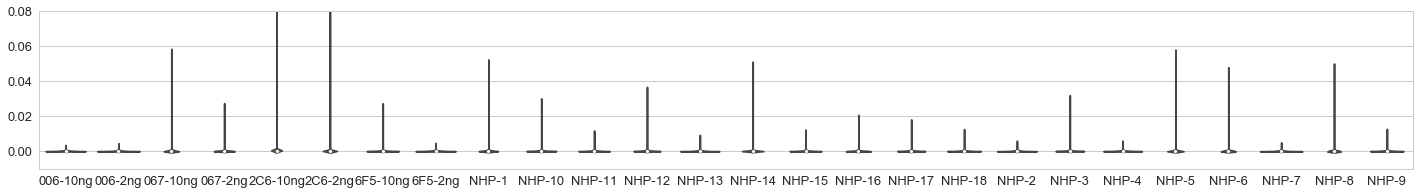

In [52]:
plt.subplots(figsize=(20,3))
sns.violinplot(data=aggregated_output, order=sorted(aggregated_output.columns.values))
plt.ylim(-.01, 0.08)
plt.tight_layout()

In [31]:
# def standardize(df):
#     ''' Standardize each column of the data frame such that mean = 0 and stddev = 1 '''
#     df = df.sub(df.mean(0), axis='columns').div(df.std(0), axis='columns')
#     return df

# def normalize(df):
#     ''' Normalize each column of the data frame so it ranges from 0 to 1'''
#     xmin = df.min(0)
#     xmax=df.max(0)
#     xmax_minus_xmin = xmax - xmin
#     df = df.sub(xmin, axis='columns').div(xmax_minus_xmin, axis='columns').multiply(100.)
#     return df

# def calc_enrichment(column, input_vals = input_counts['average'], background_vals = background_counts['average']):
#     ''' Naive first pass: output/input - background/input '''
#     background_enrichment = background_vals.div(input_vals)
#     column_enrichment = column.div(input_vals)
#     enrichment = column_enrichment.sub(background_enrichment)
#     enrichment[enrichment<0] = 0. # Take min(score, 0)
#     return enrichment

# enrichment = output_counts.apply(calc_enrichment, axis=0)

# ### This has some issues, mainly that the background is only normalized to itself, so it's highly overrepresented. TODO